<a href="https://colab.research.google.com/github/govindakolli/Pytorch/blob/main/03_Pytorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## 0. Computer vision libraries in PyTorch

* [torchvision](https://docs.pytorch.org/vision/stable/index.html) - base domain library for computer vision

* `torchvision.datasets` - get datasets and data loading functions for computer vision here

* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems

* `torchvision.transforms` - functions for manipulating your vision data(images) to be suitable for use with an ML model

* `torch.utils.data.dataset` - Base dataset class for PyTorch

* `torch.utils.data.DataLoader` - Create a Python iterable over  a dataset

In [145]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a Dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets

In [146]:
# Set up training data
train_data = datasets.FashionMNIST(
    root = 'data', # Where to download data
    train = True, # Do we want the training dataset?
    download = True, # download dataset?
    transform = ToTensor(), # # How do we want to transform the data
    target_transform = None  # How do we want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

In [147]:
len(train_data), len(test_data)

(60000, 10000)

In [148]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [149]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [150]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [151]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.1 Check the Input and Output shapes of the data

In [152]:
# Check the shape our image
image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

### 1.2 Visualizing our data

Image shape : torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

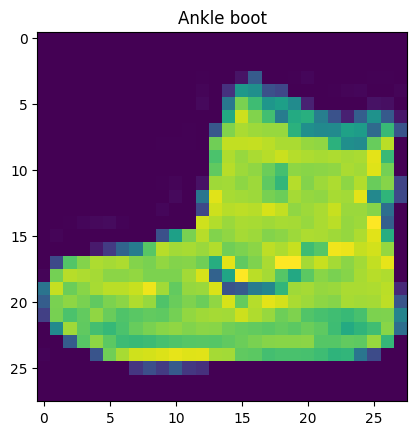

In [153]:
print(f"Image shape : {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

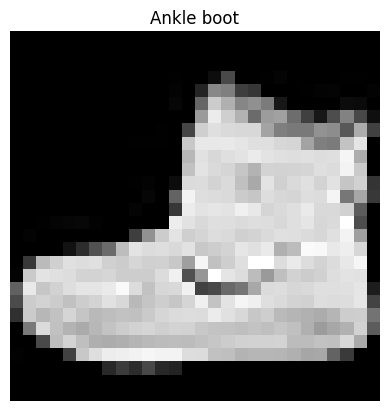

In [154]:
plt.imshow(image.squeeze(),cmap="grey")
plt.title(class_names[label])
plt.axis(False)

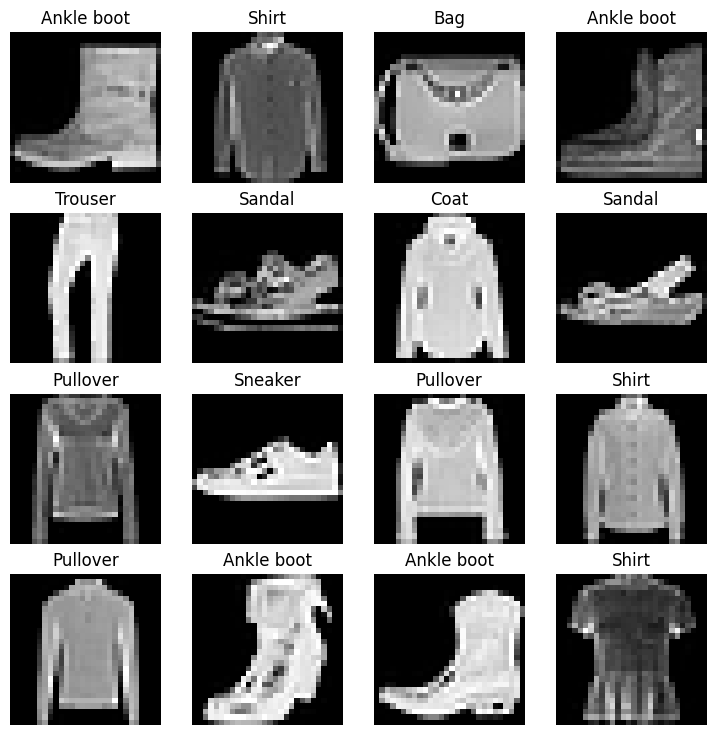

In [155]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data), size =[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(), cmap="grey")
  plt.title(class_names[label])
  plt.axis(False)

In [156]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable

More specifically, we want turn our data into batches(or mini-batches).

Why would we do this?


Because it's more computationally efficient:
In an ideal world you could do the forward pass and backward pass across all of your data at once.
But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

It also gives your model more opportunities to improve.
With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

32 is a good place to start for a fair amount of problems.
But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

In [157]:
 from torch.utils.data import DataLoader

 # Set up batch size hyperparameter
 BATCH_SIZE =32

 # Turn datasets into iterables
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f220d292150>,
 <torch.utils.data.dataloader.DataLoader at 0x7f220d2a3550>)

In [158]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [159]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

image shape : torch.Size([1, 28, 28])
label :6


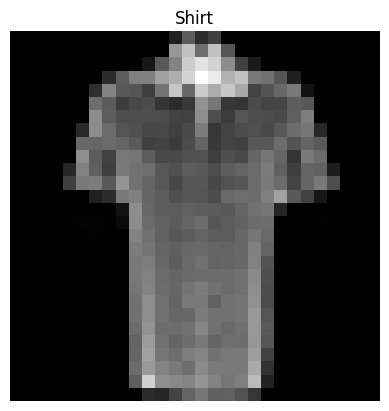

In [160]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"image shape : {img.shape}")
print(f"label :{label}")

## 3. Model 0: Build a baseline model

Start with a simple model

In [161]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

# Print out what happened
print(f"Shape before flattening : {x.shape}")
print(f"Shape after flattening : {output.shape}")

Shape before flattening : torch.Size([1, 28, 28])
Shape after flattening : torch.Size([1, 784])


In [162]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [163]:
torch.manual_seed(42)

# Set up  model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape = 784,# 28*28 = 784
    hidden_units = 10, # how many units in hidden layer
    output_shape = len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [164]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we are working with multi-class data, our loss function will be `nn.CrossEntropyLoss()
* Optimizer - SGD
* Evaluation metrics - Classification -> accuracy

In [165]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo
if Path("helper_functions.py").is_file():
  print("hepler_functions.py is existed. Skipping download")
else:
  print("Downloading hepler_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

hepler_functions.py is existed. Skipping download


In [166]:
# import accuracy metric
from helper_functions import accuracy_fn

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# Setip optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

### 3.2 Creating a function to time our experiments

Two of main things we need to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [167]:
from timeit import default_timer as timer
def print_train_time(start : float,
                     end : float,
                     device : torch.device = None):
  """ Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device} : {total_time : .3f} seconds ")
  return total_time

In [168]:
start_time = timer()
# Some code
end_time = timer()

print_train_time(start = start_time, end = end_time, device = "cpu")

Train time on cpu :  0.000 seconds 


2.8869999368907884e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out waht's happening.
5. Time it all.

In [169]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the numberof epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----")
  ### Training
  train_loss = 0

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_pred,y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. calculate the loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the accuracy average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f}, Test Acc : {test_acc:.2f}%")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu, end = train_time_end_on_cpu, device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss : 0.5904 | Test loss : 0.5095, Test Acc : 82.04%
Epoch : 1
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss : 0.4763 | Test loss : 0.4799, Test Acc : 83.20%
Epoch : 2
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss : 0.4550 | Test loss : 0.4766, Test Acc : 83.43%
Train time on cpu :  25.749 seconds 


## 4. Make predictions and get Model 0 results

In [170]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of the model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # Make our data device agnostic
      X,y = X.to(device),y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [171]:
torch.cuda.is_available()

False

In [172]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

In [173]:
# Create a model with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )

  def forward(self,x):
    return self.layer_stack(x)

In [174]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### 6.1 Setup loss, optimizer and evaluation metrics

In [175]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

### 6.2 Functioning training and evaluation/testing loops

Let's create function for :    
* training loop - `train_steo()`

* test loop - `test_step()`

In [176]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs training step on model trying to learn on data loader"""
  ### Training
  train_loss, train_acc = 0,0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    # Put data into target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss and accuracy (per batch)
    loss = loss_fn(y_pred,y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  # Divide total train loss  and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  # Print out what's happening
  print(f"Train loss : {train_loss:.5f} | Train acc : {train_acc: .2f}%")

In [177]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  """Performs testing step on trained model on data loader"""\
  ### Testing
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in data_loader:

      # Send data to the target device
      X_test,y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred = model(X_test)

      # 2. calculate the loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the accuracy average per batch
    test_acc /= len(data_loader)

  # Print out what's happening
  print(f"\nTest loss : {test_loss:.4f}, Test Acc : {test_acc:.2f}%")

In [178]:
torch.manual_seed(42)


train_time_start_on_gpu = timer()

# Set the numberof epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----")
  train_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             device = device)


train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end =train_time_end_on_gpu,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
----
Train loss : 1.09199 | Train acc :  61.34%

Test loss : 0.9273, Test Acc : 66.00%
Epoch : 1
----
Train loss : 0.73779 | Train acc :  73.69%

Test loss : 0.6879, Test Acc : 75.43%
Epoch : 2
----
Train loss : 0.66776 | Train acc :  76.08%

Test loss : 0.6433, Test Acc : 76.87%
Train time on cpu :  40.971 seconds 


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

* Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you are using has a better CPU in terms of compute capability than the GPU.

For more  - https://horace.io/brrr_intro.html

In [179]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [180]:
total_train_time_model_0

25.749041650000436

In [181]:
# Get model_1 results dictionary
model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6874349117279053,
 'model_acc': 75.65894568690096}

## 7. Model 2 : Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

for more visual CNNs - https://poloclub.github.io/cnn-explainer/

In [182]:
# Create a convolutional Nueral Network
class FashionMNISTModelV2(nn.Module):
  """Model architecture that replicates the TinyVGG
  model from CNN Explainer website."""
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1), # Values we can set ourselves in NNs are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7, # there s trick to calculating this ...
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x


In [183]:
image.shape

torch.Size([1, 28, 28])

In [184]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

In [185]:
# Pass an image through through it
#model_2(image).to(device)
model_2(image.unsqueeze(dim=0)).to(device)

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d`

In [186]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Shape of the image batch: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"test image : {test_image}")

Shape of the image batch: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
test image : tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

     

In [187]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = (3,3),
                       stride = 1,
                       padding = 1)
# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(dim=0)) # Unsqueeze is optional
conv_output.shape

torch.Size([1, 10, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d()`

In [188]:
test_image.shape

torch.Size([3, 64, 64])

In [189]:
# Print out original image shape without unsqueezed dimension
print(f"Test image shape : {test_image.shape}")
print(f"Test image unsqueezed shape : {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

#pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv layer : {test_image_through_conv.shape}")

# Pass data through the max poop layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through max pool layer : {test_image_through_conv_and_max_pool.shape}")

Test image shape : torch.Size([3, 64, 64])
Test image unsqueezed shape : torch.Size([1, 3, 64, 64])
Shape after going through conv layer : torch.Size([1, 10, 64, 64])
Shape after going through max pool layer : torch.Size([1, 10, 32, 32])


### 7.3 Setup loss function and optimizer for `model_2`

In [190]:
# Set up loss function and accuracy metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

### 7.4 Training and testing our `model_2` using our training and testing functions

In [191]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Set the numberof epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n----")
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             device = device)


train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_on_gpu,
                                            end =train_time_end_on_gpu,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
----
Train loss : 0.58653 | Train acc :  78.74%

Test loss : 0.3665, Test Acc : 86.63%
Epoch : 1
----
Train loss : 0.35992 | Train acc :  86.92%

Test loss : 0.3478, Test Acc : 87.69%
Epoch : 2
----
Train loss : 0.32392 | Train acc :  88.28%

Test loss : 0.3381, Test Acc : 87.66%
Train time on cpu :  40.971 seconds 


In [192]:
# Get model_2 results
model_2_results = eval_model(model = model_2,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn
                             )
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3638646900653839,
 'model_acc': 87.120607028754}

## 8. Compare model results and training time

In [193]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.687435,75.658946
2,FashionMNISTModelV2,0.363865,87.120607


In [194]:
compare_results["training_time"] = [total_train_time_model_0,
                                     total_train_time_model_1,
                                     total_train_time_model_2]

#compare_results = compare_results.drop(["train9ng_time"],axis=1)

In [195]:
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,25.749042
1,FashionMNISTModelV1,0.687435,75.658946,40.971293
2,FashionMNISTModelV2,0.363865,87.120607,40.971293


Text(0, 0.5, 'model')

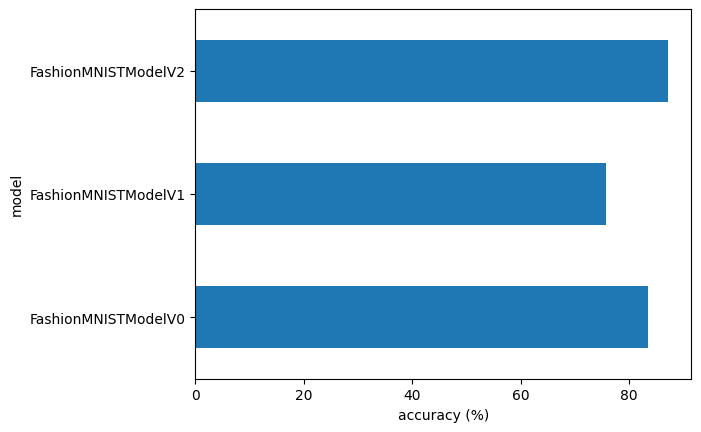

In [196]:
# VIsualize our model results
compare_results.set_index("model_name")['model_acc'].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions using our best model

In [197]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs are raw logits)
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)

      # Get pred_prob off the gpu for further calculations
      pred_probs.append(pred_prob.cpu())
  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [198]:
import random
random.seed(42)
test_sample = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_sample.append(sample)
  test_labels.append(label)

In [199]:
test_sample[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

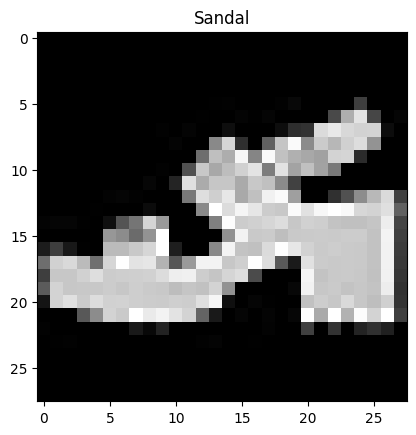

In [200]:
plt.imshow(test_sample[0].squeeze(dim=0), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [201]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data = test_sample)

# View first two prediction probabilities
pred_probs[:2]


tensor([[1.0005e-07, 5.5843e-08, 3.2755e-08, 1.8559e-08, 4.6007e-09, 9.9915e-01,
         4.4782e-08, 1.3509e-04, 1.5592e-05, 6.9479e-04],
        [4.2018e-02, 6.5532e-01, 2.9783e-04, 2.7293e-01, 1.2293e-02, 1.2231e-05,
         1.5643e-02, 2.7211e-04, 1.1782e-03, 3.7520e-05]])

In [202]:
# COnvert prediction probabilities to labels
pred_classes = torch.argmax(pred_probs,dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [203]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

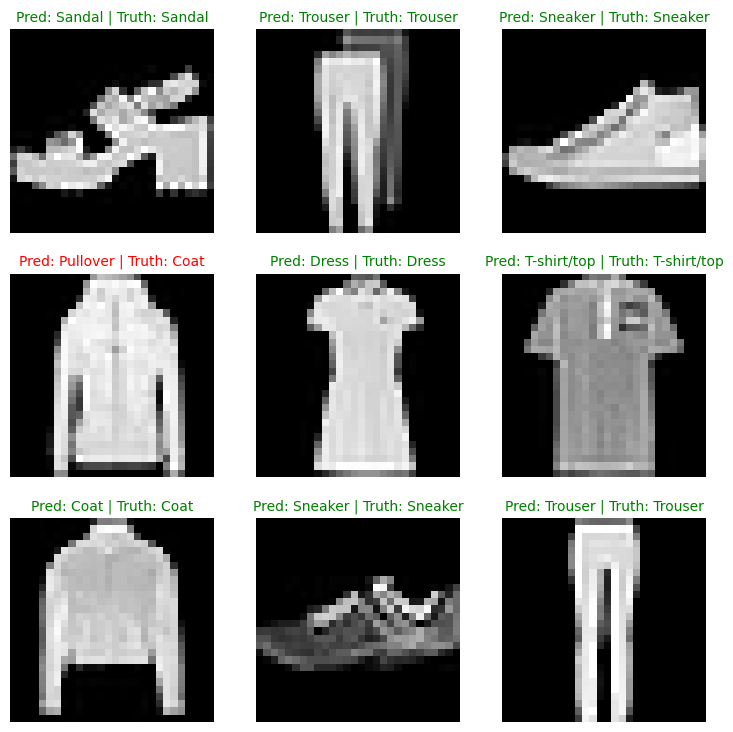

In [204]:
# Plot predictions
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_sample):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  #Plot the target image
  plt.imshow(sample.squeeze(dim=0), cmap="gray")

  # Find the prediction ( in text form e.g Sandal )
  pred_label = class_names[pred_classes[i]]

  # Get the truth tabel in text form
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix() - https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [205]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [206]:
y_pred_tensor.shape

torch.Size([10000])

In [207]:
try:
  import torchmetrics, mlxtend
  print(f"torchmetrics version : {torchmetrics.__version__}")
  print(f"mlxtend version : {mlxtend.__version__}")
except:
  !pip install -q torchmetrics -U mlxtend

  import torchmetrics, mlxtend
  print(f"torchmetrics version : {torchmetrics.__version__}")
  print(f"mlxtend version : {mlxtend.__version__}")

torchmetrics version : 1.7.2
mlxtend version : 0.23.4


In [208]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = 'multiclass', num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

confmat_tensor

tensor([[872,   0,  10,  30,   1,   1,  76,   0,  10,   0],
        [  7, 950,   0,  36,   2,   0,   3,   0,   2,   0],
        [ 15,   0, 843,  10,  44,   0,  75,   0,  13,   0],
        [ 36,   0,   3, 916,  12,   0,  29,   0,   4,   0],
        [  1,   0, 167,  64, 668,   0,  93,   0,   7,   0],
        [  0,   0,   0,   1,   0, 938,   0,  51,   1,   9],
        [177,   0,  91,  26,  60,   0, 618,   0,  28,   0],
        [  0,   0,   0,   0,   0,   4,   0, 984,   0,  12],
        [  2,   2,   0,   8,   1,   1,   3,   9, 974,   0],
        [  0,   0,   0,   1,   0,   3,   0,  48,   0, 948]])

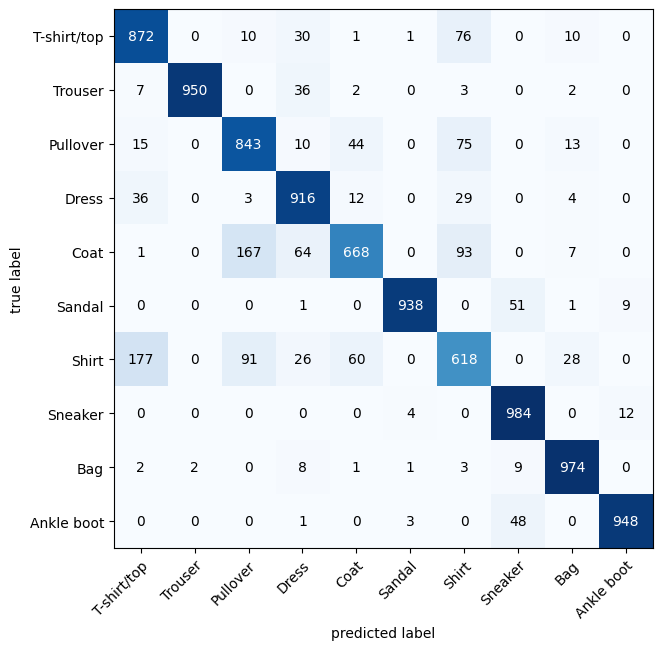

In [212]:
# 3. Plot the confusion matrix
fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=class_names,
    figsize = (10,7)
)

## 11. Save and load best performing model

In [214]:
from pathlib import Path
# Create model Directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok= True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to : models/03_pytorch_computer_vision_model_2.pt


In [215]:
# Create new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                     hidden_units = 10,
                                     output_shape = 10)

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Send model to target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [216]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(model = loaded_model_2,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [217]:
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3638646900653839,
 'model_acc': 87.120607028754}

In [218]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3638646900653839,
 'model_acc': 87.120607028754}

In [223]:
# Check if the model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
               torch.tensor(loaded_model_2_results["model_loss"]),
              atol = 1e-01)

tensor(True)